In [1]:
import numpy as np
import pandas as pd

import data

In [10]:
# PREPROCESSING

# merge all food dataframes into one
full_food = pd.concat([pd.DataFrame(x) for x in data.food.values()], axis=1)
full_food = full_food.loc[:,~full_food.columns.duplicated()]

# For now just don't include the education data at all.
full_df = full_food

# combine food and education dataframes, removing state and county from education
# education = pd.DataFrame(data.education).drop(['State', 'Area name'], axis=1)
# full_df = full_food.merge(education, left_index=True, right_index=True)

# normalize any column that isn't already boolean
bool_cols = [col for col in full_df 
                    if np.isin(full_df[col].dropna().unique(), [0, 1]).all()]
for col in full_df.columns:
    if (col in bool_cols) or (col in ['State', 'County']):
        continue
    full_df[col] = (full_df[col]-full_df[col].min())/(full_df[col].max()-full_df[col].min())

full_df = full_df.drop('County', axis=1)

# one-hot encoding for state
one_hot = pd.get_dummies(full_df['State'])
full_df = full_df.drop('State', axis=1)
full_df = full_df.join(one_hot)

# aggressively just drop any column that has any NaN values in it
full_df = full_df.dropna(axis=1)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import minmax_scale
from random import sample


X = full_df.values
y = minmax_scale(data.education["Percent of adults with a bachelor's degree or higher, 2014-18"].values)

# split into 80 / 20 training / testing
train_idx = sample(range(len(y)), int(0.8*len(y)))
train_X = [X[i] for i in train_idx]
train_y = [y[i] for i in train_idx]
test_X = [X[i] for i in range(len(X)) if i not in train_idx]
test_y = [y[i] for i in range(len(X)) if i not in train_idx]

gbr = GradientBoostingRegressor()
gbr.fit(train_X, train_y)
gbr_pred_y = gbr.predict(test_X)
gbr_score = r2_score(test_y, gbr_pred_y)

abr = AdaBoostRegressor()
abr.fit(train_X, train_y)
abr_pred_y = abr.predict(test_X)
abr_score = r2_score(test_y, abr_pred_y)

rfr = RandomForestRegressor()
rfr.fit(train_X, train_y)
rfr_pred_y = gbr.predict(test_X)
rfr_score = r2_score(test_y, rfr_pred_y)

print(gbr_score, abr_score, rfr_score)

0.8122296627143357 0.7202223762549049 0.8122296627143357


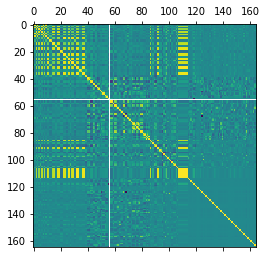

[('PCT_OBESE_ADULTS13', -0.5709770283733316),
 ('PCT_DIABETES_ADULTS13', -0.5524841414532509),
 ('PCT_NHASIAN10', 0.4690497219550212),
 ('FMRKT16', 0.4407787934182689),
 ('RECFACPTH14', 0.4381272537907822),
 ('RECFAC09', 0.4325390363776276),
 ('RECFAC14', 0.42813116574927923),
 ('LACCESS_POP10', 0.4080553102299273),
 ('METRO13', 0.4042378167208711),
 ('SNAPSPTH12', -0.40391027210281216),
 ('LACCESS_CHILD10', 0.3939422968098942),
 ('LACCESS_SENIORS10', 0.3904383328043752),
 ('FSR09', 0.3665045808764061),
 ('FSR14', 0.3664114369531254),
 ('RECFACPTH09', 0.3654801849471973),
 ('SUPERC14', 0.3514603112525136),
 ('SUPERC09', 0.3442102891419582),
 ('FFRPTH14', 0.33931914431690047),
 ('FFR14', 0.3389635345615686),
 ('FFR09', 0.33811873053103225),
 ('CONVS09', 0.3366755739390896),
 ('FFRPTH09', 0.33571684133270324),
 ('CONVS14', 0.3330673609697035),
 ('PERCHLDPOV10', -0.32728707780185057),
 ('Population Estimate, 2016', 0.32695764718946674),
 ('PCT_LACCESS_HHNV10', -0.326642794120152),
 ('Popu

In [22]:
import matplotlib.pyplot as plt

# visualize correlation between predictors
plt.matshow(full_df.corr())
plt.show()

# list correlation between each predictor and the outcome
correlations = [(column, np.corrcoef(full_df[column].values, y)[0, 1]) for column in full_df.columns]
sorted(correlations, key=lambda t: abs(t[1]), reverse=True)